In [5]:
# Import your updated database
import sys
sys.path.append('../src')
from models.database import CDSDatabase

# Create database instance 
db = CDSDatabase("data/raw/cds_indices_raw.db")

# Populate with 10 years of historical data
#db.populate_historical_raw_data(years_back=10)

print("Database creation complete!")

Populating historical raw data
Date range: 2015-09-19 to 2025-09-16
Processing 2607 business days...
  Progress: 1/2607 days (2015-09-21)
  Progress: 101/2607 days (2016-02-08)
  Progress: 201/2607 days (2016-06-27)
  Progress: 301/2607 days (2016-11-14)
  Progress: 401/2607 days (2017-04-03)
  Progress: 501/2607 days (2017-08-21)
  Progress: 601/2607 days (2018-01-08)
  Progress: 701/2607 days (2018-05-28)
  Progress: 801/2607 days (2018-10-15)
  Progress: 901/2607 days (2019-03-04)
  Progress: 1001/2607 days (2019-07-22)
  Progress: 1101/2607 days (2019-12-09)
  Progress: 1201/2607 days (2020-04-27)
  Progress: 1301/2607 days (2020-09-14)
  Progress: 1401/2607 days (2021-02-01)
  Progress: 1501/2607 days (2021-06-21)
  Progress: 1601/2607 days (2021-11-08)
  Progress: 1701/2607 days (2022-03-28)
  Progress: 1801/2607 days (2022-08-15)
  Progress: 1901/2607 days (2023-01-02)
  Progress: 2001/2607 days (2023-05-22)
  Progress: 2101/2607 days (2023-10-09)
  Progress: 2201/2607 days (202

In [10]:
db = CDSDatabase("data/raw/cds_indices_raw.db")
# Query historical data to verify it worked
df = db.query_historical_spreads('US_HY', '3Y', '2020-01-01')

print(f"US HY 3Y data points: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nSample data:")
print(df[['date', 'spread_bps', 'series_number', 'bloomberg_ticker']].head())

# Check all indices
summary = db.conn.execute("""
    SELECT index_name, tenor, COUNT(*) as records, 
           MIN(date) as first_date, MAX(date) as last_date,
           MIN(series_number) as min_series, MAX(series_number) as max_series
    FROM raw_historical_spreads 
    GROUP BY index_name, tenor
    ORDER BY index_name, tenor
""").fetchall()

print(f"\nDatabase Summary:")
for row in summary:
    index_name, tenor, records, first_date, last_date, min_series, max_series = row
    print(f"  {index_name} {tenor}: {records:,} records ({first_date} to {last_date}, S{min_series}-S{max_series})")

# db.close()

US HY 3Y data points: 657
Date range: 2020-04-13 00:00:00 to 2025-09-15 00:00:00

Sample data:
        date  spread_bps  series_number      bloomberg_ticker
0 2025-09-15     343.594             44  CDXHY344 BEST Curncy
1 2025-09-12     344.075             44  CDXHY344 BEST Curncy
2 2025-09-11     344.179             44  CDXHY344 BEST Curncy
3 2025-09-10     344.297             44  CDXHY344 BEST Curncy
4 2025-09-09     344.498             44  CDXHY344 BEST Curncy

Database Summary:
  EU_IG 10Y: 2,580 records (2015-09-21 to 2025-09-15, S24-S43)
  EU_IG 1Y: 249 records (2024-09-23 to 2025-09-16, S42-S43)
  EU_IG 3Y: 1,507 records (2019-09-23 to 2025-09-16, S32-S43)
  EU_IG 5Y: 2,516 records (2015-09-21 to 2025-09-16, S24-S43)
  EU_IG 7Y: 1,675 records (2018-09-20 to 2025-09-15, S30-S43)
  EU_XO 10Y: 2,307 records (2016-09-20 to 2025-09-15, S26-S43)
  EU_XO 3Y: 769 records (2022-09-20 to 2025-09-15, S38-S43)
  EU_XO 5Y: 2,529 records (2015-09-21 to 2025-09-16, S24-S43)
  EU_XO 7Y: 1,758 re

Testing CDS Database Plotting Capabilities
1. Testing historical spread evolution...
   ✓ Plotted 931 US HY data points
2. Testing current curve visualization...
   ✓ Plotted curves for 4 indices
3. Testing series roll visualization...
   ✓ Plotted 12 different series
4. Testing data quality heatmap...
   ✓ Created availability heatmap for 16 series


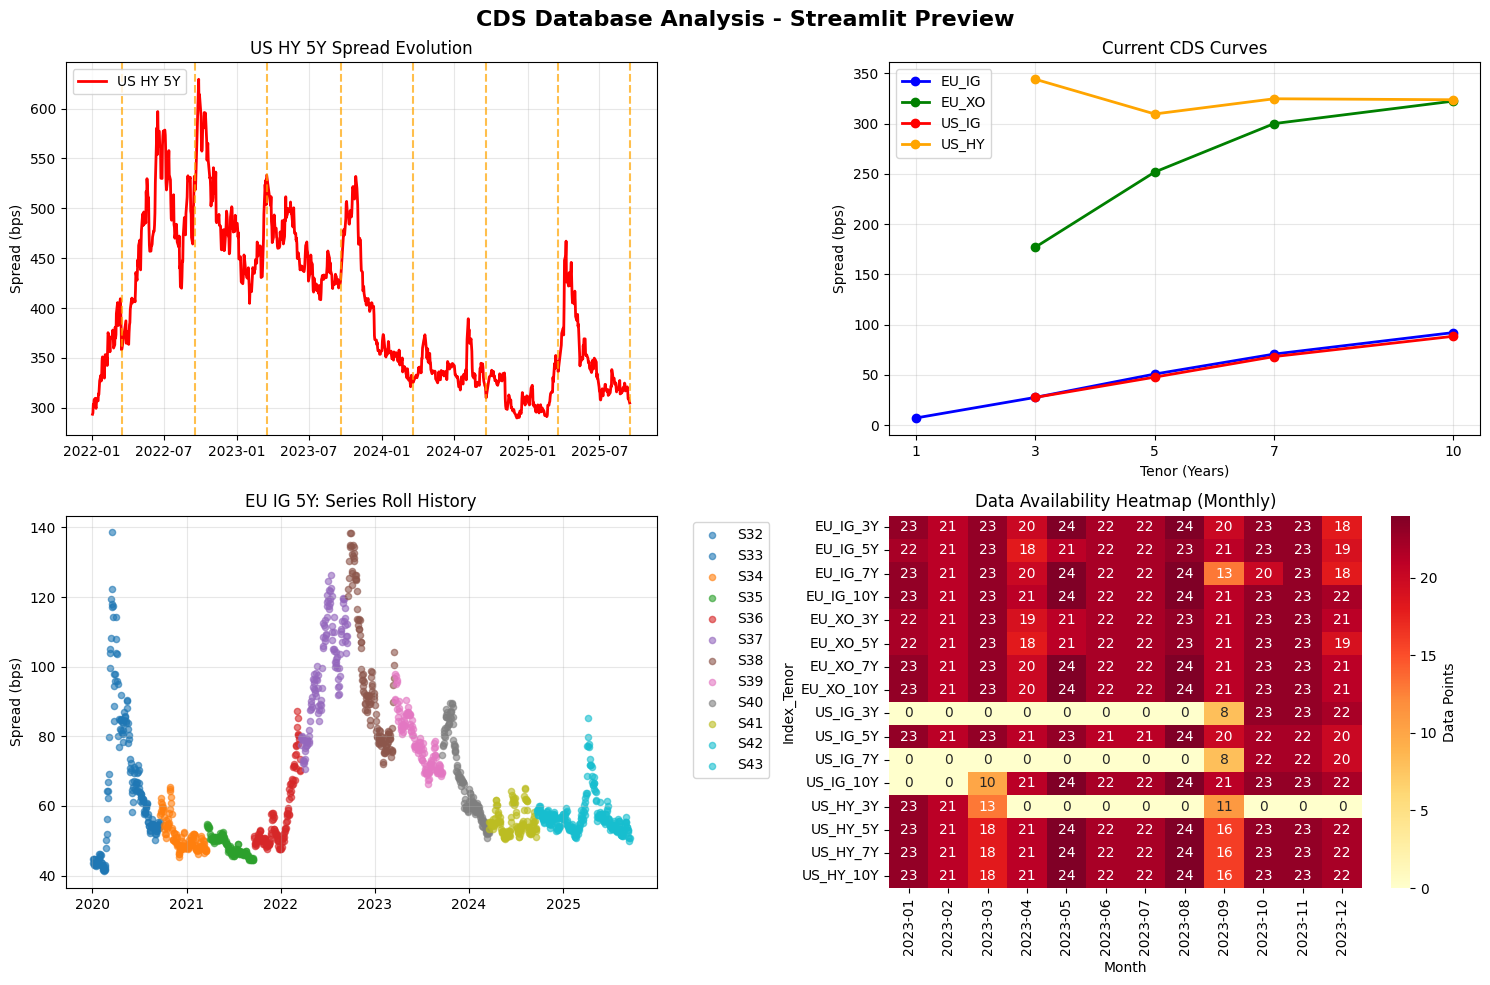


DATABASE SUMMARY STATISTICS
Total Records: 27,002
Date Range: 2015-09-21 to 2025-09-16
Series Range: S24 to S44

Per Index-Tenor Breakdown:
  EU_IG 1Y: 249 records, avg spread: 12.1 bps, range: 7.2-26.0 bps
  EU_IG 3Y: 1,507 records, avg spread: 43.3 bps, range: 20.9-120.2 bps
  EU_IG 5Y: 2,516 records, avg spread: 66.3 bps, range: 41.3-138.5 bps
  EU_IG 7Y: 1,675 records, avg spread: 85.8 bps, range: 61.1-154.2 bps
  EU_IG 10Y: 2,580 records, avg spread: 105.3 bps, range: 80.6-164.0 bps
  EU_XO 3Y: 769 records, avg spread: 299.5 bps, range: 177.1-602.2 bps
  EU_XO 5Y: 2,529 records, avg spread: 323.2 bps, range: 203.7-707.6 bps
  EU_XO 7Y: 1,758 records, avg spread: 371.9 bps, range: 242.1-710.2 bps
  EU_XO 10Y: 2,307 records, avg spread: 383.2 bps, range: 262.7-722.5 bps
  US_HY 3Y: 1,061 records, avg spread: 333.5 bps, range: 180.2-784.4 bps
  US_HY 5Y: 1,923 records, avg spread: 376.5 bps, range: 269.0-781.9 bps
  US_HY 7Y: 1,916 records, avg spread: 399.2 bps, range: 297.7-767.9 

In [11]:
# CDS Database Plotting Test - Preview for Streamlit functionality
# Test plotting capabilities once database is created

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

def test_database_plotting(db):
    """
    Test plotting functions for CDS data - preview of Streamlit functionality
    """
    
    print("Testing CDS Database Plotting Capabilities")
    print("=" * 60)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CDS Database Analysis - Streamlit Preview', fontsize=16, fontweight='bold')
    
    # Test 1: Historical spread evolution by index
    print("1. Testing historical spread evolution...")
    try:
        # Get US HY 5Y data for last 2 years
        df_hy = db.query_historical_spreads('US_HY', '5Y', 
                                           start_date='2022-01-01')
        
        if not df_hy.empty:
            axes[0,0].plot(df_hy['date'], df_hy['spread_bps'], 
                          linewidth=2, color='red', label='US HY 5Y')
            axes[0,0].set_title('US HY 5Y Spread Evolution')
            axes[0,0].set_ylabel('Spread (bps)')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].legend()
            
            # Add series roll markers
            series_changes = df_hy[df_hy['series_number'] != df_hy['series_number'].shift(1)]
            for date in series_changes['date']:
                axes[0,0].axvline(x=date, color='orange', linestyle='--', alpha=0.7)
            
            print(f"   ✓ Plotted {len(df_hy)} US HY data points")
        else:
            axes[0,0].text(0.5, 0.5, 'No US HY data available', 
                          ha='center', va='center', transform=axes[0,0].transAxes)
            
    except Exception as e:
        print(f"   ✗ US HY plotting failed: {e}")
        axes[0,0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[0,0].transAxes)
    
    # Test 2: Current curve shapes
    print("2. Testing current curve visualization...")
    try:
        current_curves = {}
        tenors_order = ['1Y', '3Y', '5Y', '7Y', '10Y']
        
        # Get latest data for each index
        for index_name in ['EU_IG', 'EU_XO', 'US_IG', 'US_HY']:
            curve_data = []
            for tenor in tenors_order:
                df = db.query_historical_spreads(index_name, tenor, 
                                                start_date=(datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d'))
                if not df.empty:
                    latest_spread = df.iloc[-1]['spread_bps']
                    curve_data.append({'tenor': tenor, 'spread': latest_spread})
            
            if curve_data:
                current_curves[index_name] = pd.DataFrame(curve_data)
        
        # Plot current curves
        colors = ['blue', 'green', 'red', 'orange']
        tenor_positions = {'1Y': 1, '3Y': 3, '5Y': 5, '7Y': 7, '10Y': 10}
        
        for i, (index_name, curve_df) in enumerate(current_curves.items()):
            if not curve_df.empty:
                x_vals = [tenor_positions[t] for t in curve_df['tenor']]
                axes[0,1].plot(x_vals, curve_df['spread'], 'o-', 
                              color=colors[i % len(colors)], 
                              label=index_name, linewidth=2, markersize=6)
        
        axes[0,1].set_title('Current CDS Curves')
        axes[0,1].set_xlabel('Tenor (Years)')
        axes[0,1].set_ylabel('Spread (bps)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_xticks([1, 3, 5, 7, 10])
        
        print(f"   ✓ Plotted curves for {len(current_curves)} indices")
        
    except Exception as e:
        print(f"   ✗ Curve plotting failed: {e}")
        axes[0,1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[0,1].transAxes)
    
    # Test 3: Series roll analysis
    print("3. Testing series roll visualization...")
    try:
        # Get EU IG 5Y data to show series changes
        df_eu = db.query_historical_spreads('EU_IG', '5Y', 
                                           start_date='2020-01-01')
        
        if not df_eu.empty:
            # Create scatter plot colored by series
            series_colors = plt.cm.tab10(np.linspace(0, 1, len(df_eu['series_number'].unique())))
            series_color_map = dict(zip(sorted(df_eu['series_number'].unique()), series_colors))
            
            for series_num in sorted(df_eu['series_number'].unique()):
                series_data = df_eu[df_eu['series_number'] == series_num]
                axes[1,0].scatter(series_data['date'], series_data['spread_bps'], 
                                 c=[series_color_map[series_num]], 
                                 label=f'S{series_num}', alpha=0.6, s=20)
            
            axes[1,0].set_title('EU IG 5Y: Series Roll History')
            axes[1,0].set_ylabel('Spread (bps)')
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[1,0].grid(True, alpha=0.3)
            
            print(f"   ✓ Plotted {len(df_eu['series_number'].unique())} different series")
        else:
            axes[1,0].text(0.5, 0.5, 'No EU IG data available', 
                          ha='center', va='center', transform=axes[1,0].transAxes)
            
    except Exception as e:
        print(f"   ✗ Series roll plotting failed: {e}")
        axes[1,0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[1,0].transAxes)
    
    # Test 4: Data quality heatmap
    print("4. Testing data quality heatmap...")
    try:
        # Create data availability matrix
        date_range = pd.date_range(start='2023-01-01', 
                                  end=datetime.now().strftime('%Y-%m-%d'), freq='D')
        
        indices = ['EU_IG', 'EU_XO', 'US_IG', 'US_HY']
        tenors = ['3Y', '5Y', '7Y', '10Y']  # Common tenors
        
        # Create availability matrix
        availability_matrix = []
        
        for month in pd.date_range(start='2023-01-01', end='2024-12-31', freq='MS')[:12]:
            month_data = {}
            for index_name in indices:
                for tenor in tenors:
                    df = db.query_historical_spreads(
                        index_name, tenor, 
                        start_date=month.strftime('%Y-%m-%d'),
                        end_date=(month + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
                    )
                    month_data[f"{index_name}_{tenor}"] = len(df) if not df.empty else 0
            
            month_data['month'] = month.strftime('%Y-%m')
            availability_matrix.append(month_data)
        
        if availability_matrix:
            avail_df = pd.DataFrame(availability_matrix)
            avail_df.set_index('month', inplace=True)
            
            # Create heatmap
            sns.heatmap(avail_df.T, annot=True, fmt='d', cmap='YlOrRd', 
                       ax=axes[1,1], cbar_kws={'label': 'Data Points'})
            axes[1,1].set_title('Data Availability Heatmap (Monthly)')
            axes[1,1].set_xlabel('Month')
            axes[1,1].set_ylabel('Index_Tenor')
            
            print(f"   ✓ Created availability heatmap for {len(avail_df.columns)} series")
        else:
            axes[1,1].text(0.5, 0.5, 'No data for heatmap', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            
    except Exception as e:
        print(f"   ✗ Heatmap creation failed: {e}")
        axes[1,1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', 
                      transform=axes[1,1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("DATABASE SUMMARY STATISTICS")
    print("="*60)
    
    try:
        total_records = db.conn.execute("SELECT COUNT(*) FROM raw_historical_spreads").fetchone()[0]
        
        summary_query = """
            SELECT index_name, tenor, 
                   COUNT(*) as records,
                   MIN(date) as first_date,
                   MAX(date) as last_date,
                   MIN(series_number) as min_series,
                   MAX(series_number) as max_series,
                   AVG(spread_bps) as avg_spread,
                   MIN(spread_bps) as min_spread,
                   MAX(spread_bps) as max_spread
            FROM raw_historical_spreads 
            GROUP BY index_name, tenor
            ORDER BY index_name, 
                     CASE tenor 
                         WHEN '1Y' THEN 1 
                         WHEN '3Y' THEN 2 
                         WHEN '5Y' THEN 3 
                         WHEN '7Y' THEN 4 
                         WHEN '10Y' THEN 5 
                     END
        """
        
        summary_df = pd.read_sql_query(summary_query, db.conn)
        
        print(f"Total Records: {total_records:,}")
        print(f"Date Range: {summary_df['first_date'].min()} to {summary_df['last_date'].max()}")
        print(f"Series Range: S{summary_df['min_series'].min()} to S{summary_df['max_series'].max()}")
        print("\nPer Index-Tenor Breakdown:")
        
        for _, row in summary_df.iterrows():
            print(f"  {row['index_name']} {row['tenor']}: {row['records']:,} records, "
                  f"avg spread: {row['avg_spread']:.1f} bps, "
                  f"range: {row['min_spread']:.1f}-{row['max_spread']:.1f} bps")
        
    except Exception as e:
        print(f"Error generating summary: {e}")
    
    print("\n" + "="*60)
    print("STREAMLIT PREVIEW COMPLETE")
    print("Ready for:")
    print("- Interactive curve plotting")  
    print("- Historical spread analysis")
    print("- Series roll visualization")
    print("- Data quality monitoring")
    print("- Strategy backtesting interface")
    print("="*60)

# Usage in notebook:
test_database_plotting(db)

In [12]:
db.close()